In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

from datasets import get_dataset    
from loss_fns import get_loss
from utils import solve

torch.set_default_dtype(torch.float64)

from sklearn.datasets import load_svmlight_file

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/sps2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cpu')

In [3]:
def logreg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def grad_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( (r/(1 + r)) @ (X * -y[:, None]) ) / X.shape[0]

def hess_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    rr = r / (1 + r)**2
    return ( X.T @ torch.diagflat(rr)  @ X ) / X.shape[0]

In [7]:
batch_size = 64
# dataset_name = "covtype.libsvm.binary"
dataset_name = "mushrooms"
percentage = 1.0

EPOCHS = 100
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("DATASETS_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray())
train_target = torch.tensor(trainY)

# CHANGE THIS ACCODRING TO DATASET AND LOSS FUNCTION
train_target[train_target == 2.] == -1.

train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)


scale = 10
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = data_utils.TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=True)

In [8]:
func = logreg
grad = grad_logreg
hess = hess_logreg

In [9]:
def sgd(train_data, train_target, train_dataloader, lr):
    w = torch.zeros(train_data.shape[1])

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)

            with torch.no_grad():
                w.sub_(lr * g)
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [10]:
hist_sgd = sgd(train_data, train_target, train_dataloader, 0.01)

In [42]:
def adagrad(train_data, train_target, train_dataloader, lr):
    w = torch.zeros(train_data.shape[1])

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    precond = torch.zeros_like(g)

    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)
            precond.add_(torch.square(g))
            precond_inv = 1 / (torch.sqrt(precond) + 1e-10) 

            with torch.no_grad():
                w.sub_(lr * precond_inv * g)
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [43]:
hist_adagrad_1 = adagrad(train_data, train_target, train_dataloader, 0.01)

In [44]:
hist_adagrad_2 = adagrad(train_data, train_target, train_dataloader, 0.1) 

In [45]:
hist_adagrad_3 = adagrad(train_data, train_target, train_dataloader, 1.0)

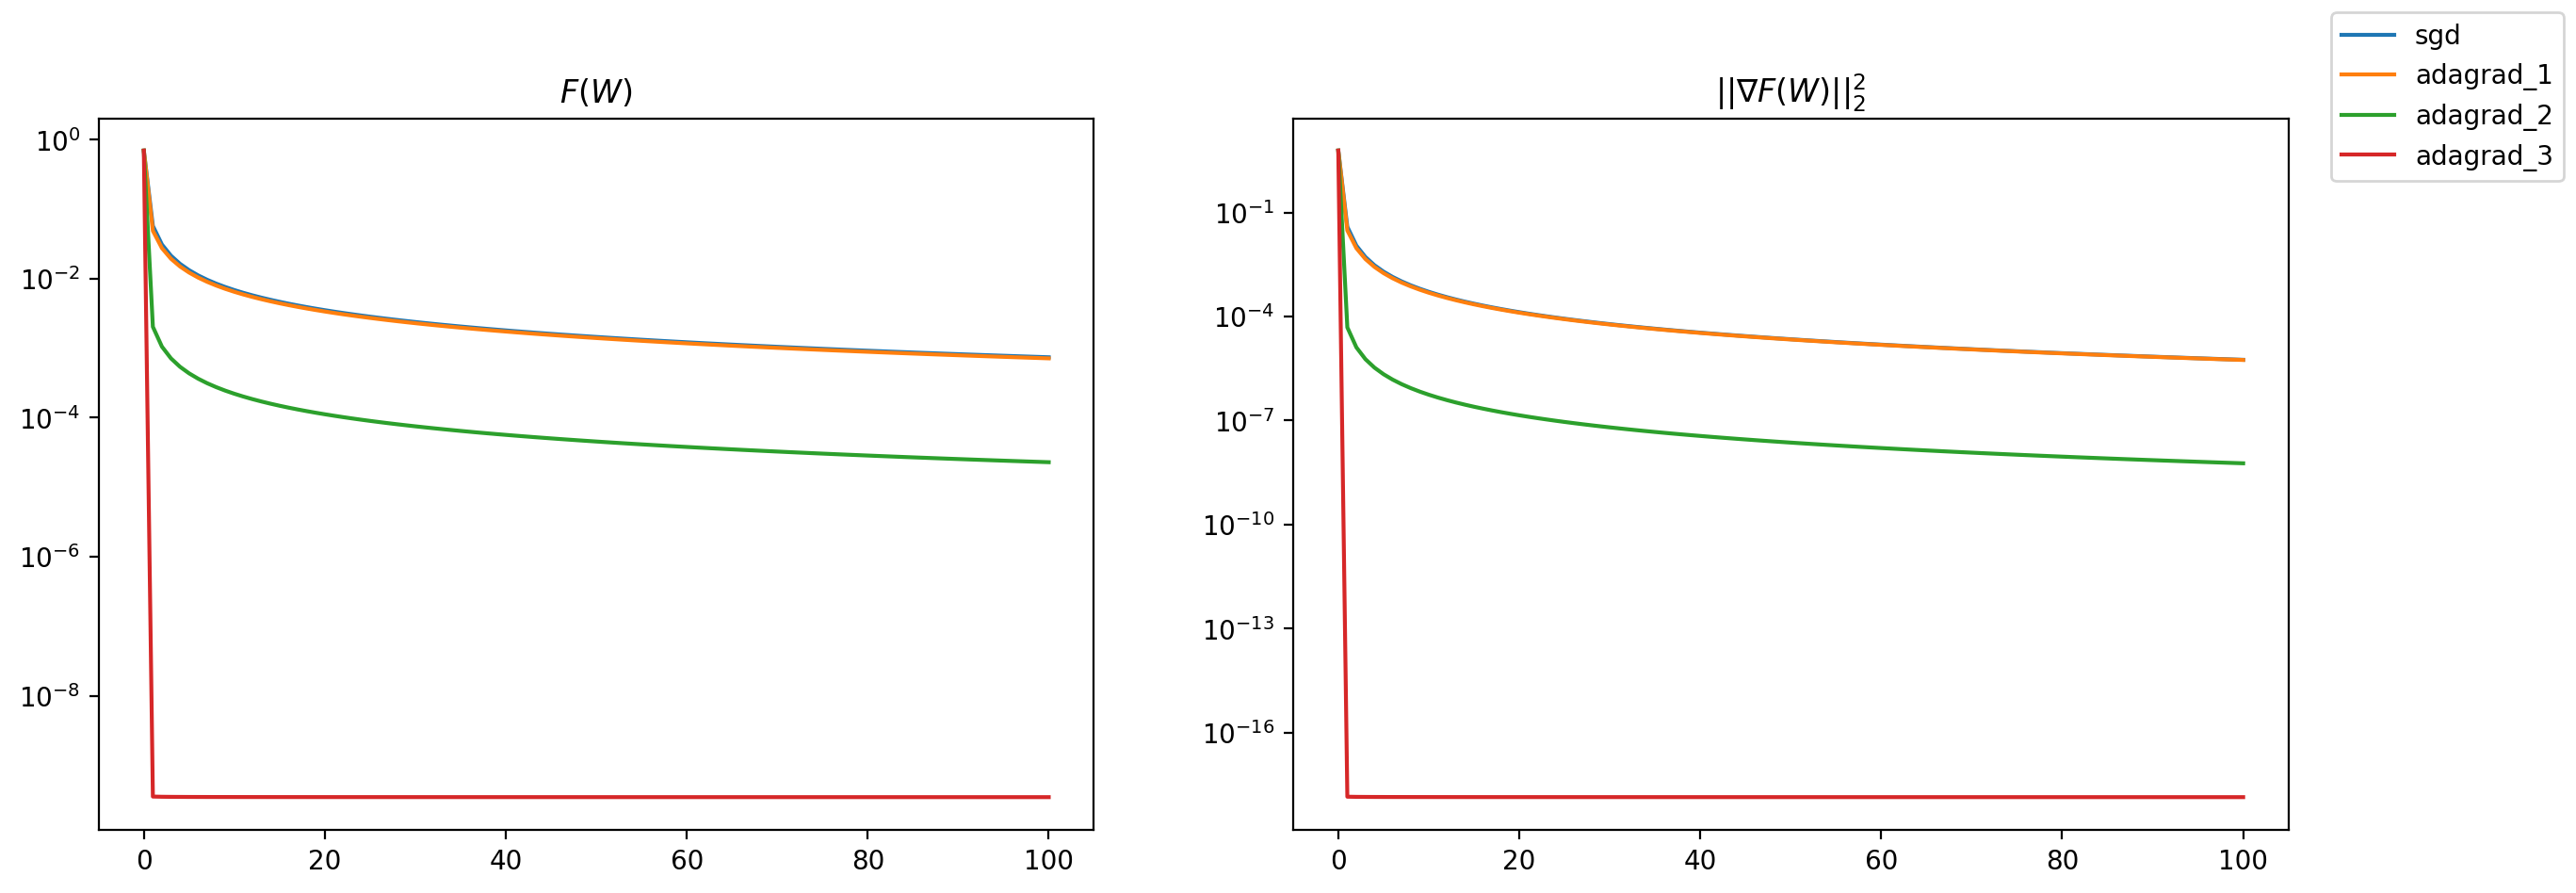

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1.semilogy([x[0] for x in hist_sgd], label="sgd")
ax2.semilogy([x[1] for x in hist_sgd])

ax1.semilogy([x[0] for x in hist_adagrad_1], label="adagrad_1")
ax2.semilogy([x[1] for x in hist_adagrad_1])

ax1.semilogy([x[0] for x in hist_adagrad_2], label="adagrad_2")
ax2.semilogy([x[1] for x in hist_adagrad_2])

ax1.semilogy([x[0] for x in hist_adagrad_3], label="adagrad_3")
ax2.semilogy([x[1] for x in hist_adagrad_3])

ax1.set_title(r"$F(W)$")
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")

fig.legend()

In [22]:
from torch.optim import SGD, Adam, Adagrad, Adadelta, RMSprop
from torch_optimizer import Adahessian

In [47]:
def run_optimizer(optim, lr):
    # parameters
    w = torch.zeros(train_data.shape[1]).requires_grad_()
    optimizer = optim([w], lr=lr)

    # save loss and grad size to history
    hist = []
    loss = func(w, train_data, train_target)
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

    for step in range(EPOCHS):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            loss = func(w, batch_data, batch_target)
            if isinstance(optimizer, Adahessian): 
                loss.backward(create_graph=True)
            else:
                loss.backward()
            optimizer.step()

        loss = func(w, train_data, train_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

        if step % 10 == 0 or step == EPOCHS-1:
            print(f"Epoch [{step}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    return hist

In [48]:
hist_adagrad_optim_1 = run_optimizer(Adagrad, 0.01)

Loss: 0.6931471805599453 | GradNorm^2: 6.057377027322154
Epoch [0] | Loss: 0.048747714120068036 | GradNorm^2: 0.030149340904947315
Epoch [10] | Loss: 0.005903789362600009 | GradNorm^2: 0.00040432687907769046
Epoch [20] | Loss: 0.003202464696893276 | GradNorm^2: 0.00011689779158197185
Epoch [30] | Loss: 0.002205721636050027 | GradNorm^2: 5.494383000355023e-05
Epoch [40] | Loss: 0.0016849581462298627 | GradNorm^2: 3.186933290570881e-05
Epoch [50] | Loss: 0.0013643622863539282 | GradNorm^2: 2.080439776026184e-05
Epoch [60] | Loss: 0.0011468994669270934 | GradNorm^2: 1.4651512532004845e-05
Epoch [70] | Loss: 0.0009895960876425227 | GradNorm^2: 1.0878548898531746e-05
Epoch [80] | Loss: 0.0008704624623564724 | GradNorm^2: 8.398086264979496e-06
Epoch [90] | Loss: 0.0007770817645070714 | GradNorm^2: 6.680168993464712e-06
Epoch [99] | Loss: 0.0007087552593063729 | GradNorm^2: 5.548822012226067e-06


In [49]:
hist_adagrad_optim_2 = run_optimizer(Adagrad, 0.1)

Loss: 0.6931471805599453 | GradNorm^2: 6.057377027322154
Epoch [0] | Loss: 0.0020513900762448274 | GradNorm^2: 4.875187180345728e-05
Epoch [10] | Loss: 0.00020114110347284388 | GradNorm^2: 4.5493216332624297e-07
Epoch [20] | Loss: 0.00010640777902153917 | GradNorm^2: 1.2665079838562797e-07
Epoch [30] | Loss: 7.243896028377729e-05 | GradNorm^2: 5.853741123094995e-08
Epoch [40] | Loss: 5.494473276662165e-05 | GradNorm^2: 3.361888663051999e-08
Epoch [50] | Loss: 4.427212875372447e-05 | GradNorm^2: 2.1799414663186364e-08
Epoch [60] | Loss: 3.707980380118822e-05 | GradNorm^2: 1.527698176356649e-08
Epoch [70] | Loss: 3.190270507158098e-05 | GradNorm^2: 1.1300004024385073e-08
Epoch [80] | Loss: 2.7997323770761727e-05 | GradNorm^2: 8.697108785027323e-09
Epoch [90] | Loss: 2.4945990504609067e-05 | GradNorm^2: 6.90087324366382e-09
Epoch [99] | Loss: 2.271893747306894e-05 | GradNorm^2: 5.721249018234808e-09


In [50]:
hist_adagrad_optim_3 = run_optimizer(Adagrad, 1)

Loss: 0.6931471805599453 | GradNorm^2: 6.057377027322154
Epoch [0] | Loss: 3.6329183957787316e-10 | GradNorm^2: 1.4960780479230982e-18
Epoch [10] | Loss: 3.6091339304978183e-10 | GradNorm^2: 1.4825371424061877e-18
Epoch [20] | Loss: 3.606742748437485e-10 | GradNorm^2: 1.4811742931363918e-18
Epoch [30] | Loss: 3.605741425117701e-10 | GradNorm^2: 1.4805925732732728e-18
Epoch [40] | Loss: 3.6051624148385925e-10 | GradNorm^2: 1.4802478549987504e-18
Epoch [50] | Loss: 3.6047693163520254e-10 | GradNorm^2: 1.480007406110128e-18
Epoch [60] | Loss: 3.6044751132635884e-10 | GradNorm^2: 1.4798224123199048e-18
Epoch [70] | Loss: 3.604239881548804e-10 | GradNorm^2: 1.4796704756311524e-18
Epoch [80] | Loss: 3.6040425745277673e-10 | GradNorm^2: 1.4795398074909465e-18
Epoch [90] | Loss: 3.603871260172815e-10 | GradNorm^2: 1.4794237097833697e-18
Epoch [99] | Loss: 3.603733123501882e-10 | GradNorm^2: 1.479328213073315e-18


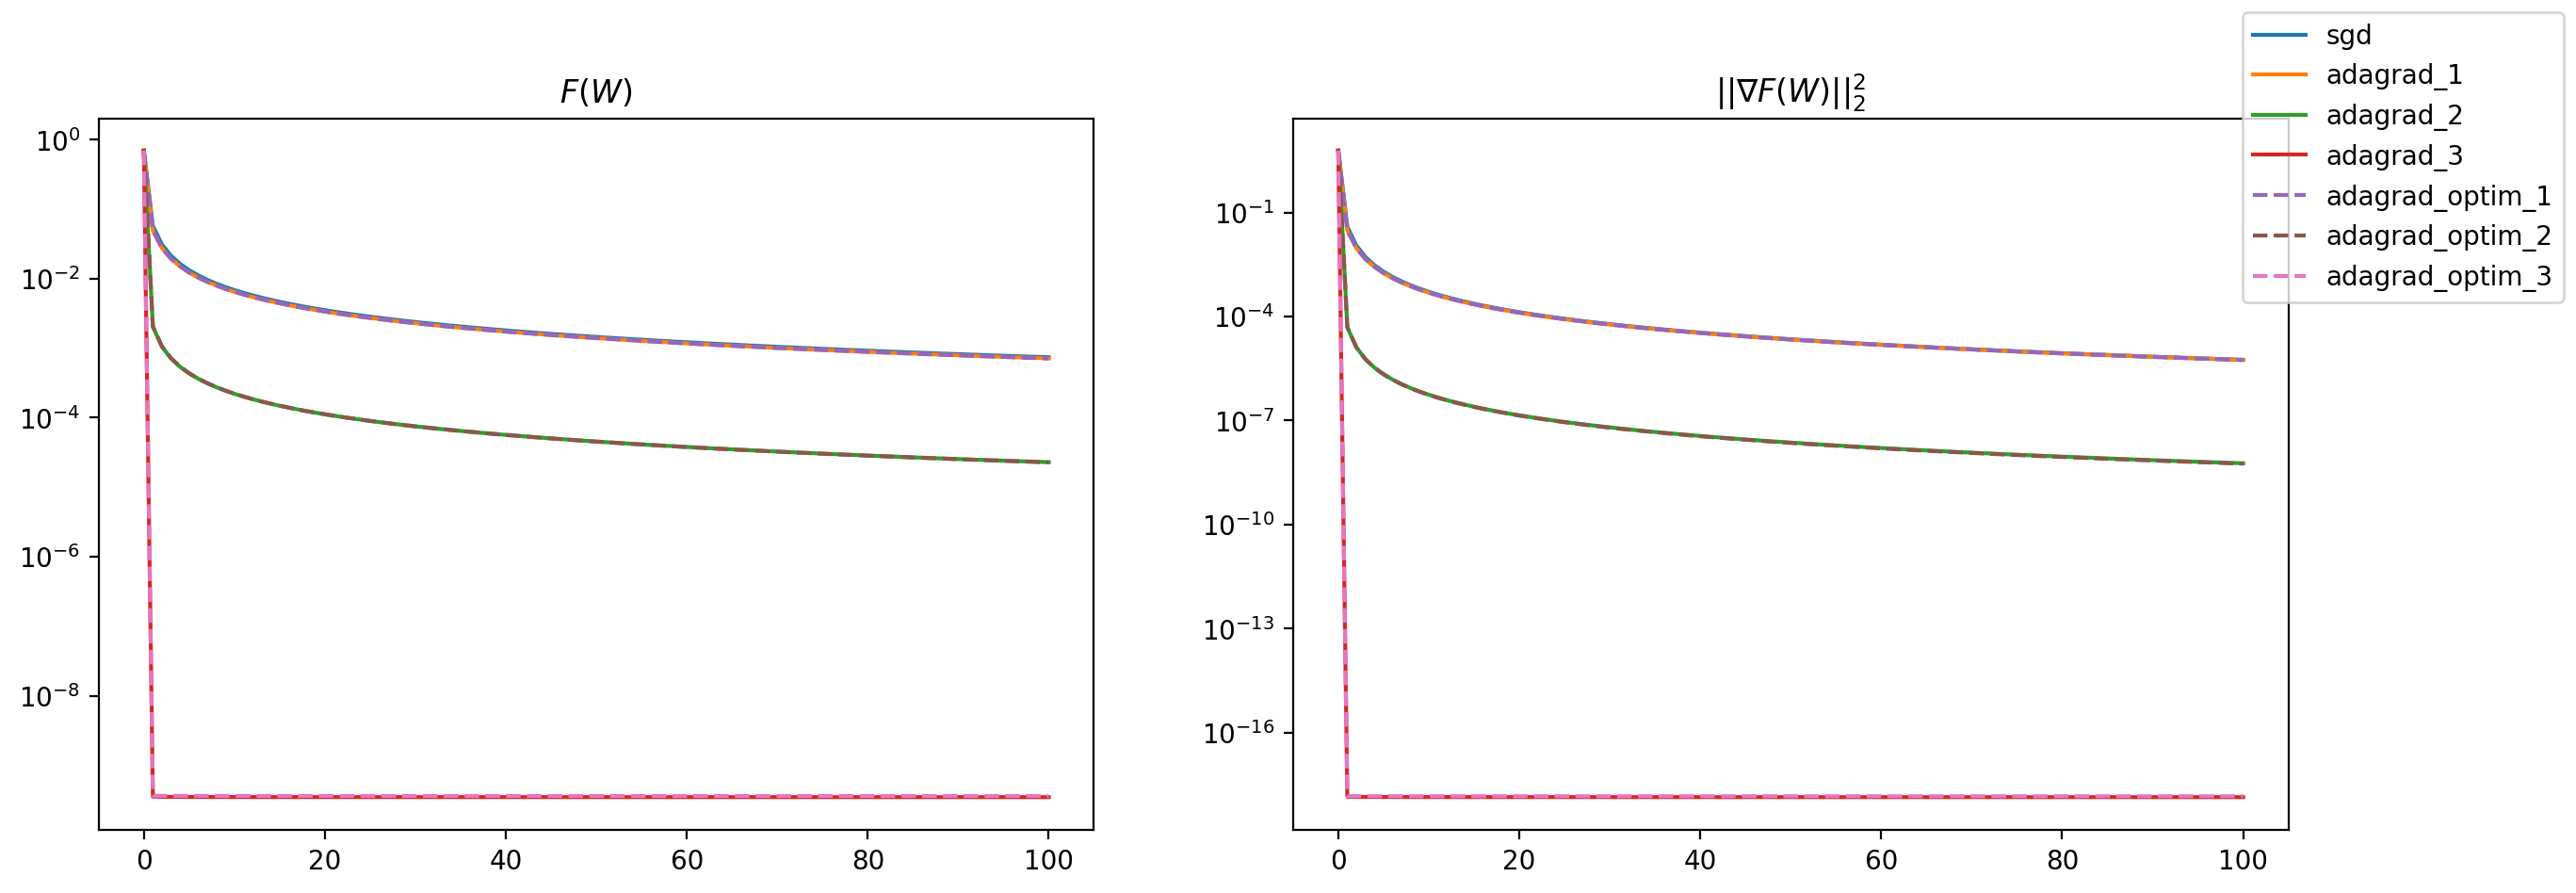

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1.semilogy([x[0] for x in hist_sgd], label="sgd")
ax2.semilogy([x[1] for x in hist_sgd])

ax1.semilogy([x[0] for x in hist_adagrad_1], label="adagrad_1")
ax2.semilogy([x[1] for x in hist_adagrad_1])

ax1.semilogy([x[0] for x in hist_adagrad_2], label="adagrad_2")
ax2.semilogy([x[1] for x in hist_adagrad_2])

ax1.semilogy([x[0] for x in hist_adagrad_3], label="adagrad_3")
ax2.semilogy([x[1] for x in hist_adagrad_3])

ax1.semilogy([x[0] for x in hist_adagrad_optim_1], linestyle="--", label="adagrad_optim_1")
ax2.semilogy([x[1] for x in hist_adagrad_optim_1], linestyle="--")

ax1.semilogy([x[0] for x in hist_adagrad_optim_2], linestyle="--", label="adagrad_optim_2")
ax2.semilogy([x[1] for x in hist_adagrad_optim_2], linestyle="--")

ax1.semilogy([x[0] for x in hist_adagrad_optim_3], linestyle="--", label="adagrad_optim_3")
ax2.semilogy([x[1] for x in hist_adagrad_optim_3], linestyle="--")



ax1.set_title(r"$F(W)$")
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")

fig.legend()

In [72]:
def adam(train_data, train_target, train_dataloader, lr):
    w = torch.zeros(train_data.shape[1])

    loss = func(w, train_data, train_target)
    g = grad(w, train_data, train_target)
    
    hist = [[loss.item(), torch.sum(torch.square(g)).item()]]

    betas = (0.9, 0.999)
    m = torch.zeros_like(g)
    v = torch.zeros_like(g)
    step_t = torch.tensor(0.)
    for epoch in range(EPOCHS):

        for batch_data, batch_target in train_dataloader:

            loss = func(w, batch_data, batch_target)
            g = grad(w, batch_data, batch_target)

            step_t += 1

            m = betas[0] * m + (1 - betas[0]) * g
            v = betas[1] * v + (1 - betas[1]) * g.square()
            m_hat = m / (1 - torch.pow(betas[0], step_t))
            v_hat = v / (1 - torch.pow(betas[1], step_t))
            

            with torch.no_grad():
                w.sub_((lr / (torch.sqrt(v_hat) + 1e-8)) * m_hat)
                
        
        loss = func(w, train_data, train_target)
        g = grad(w, train_data, train_target)

        hist.append([loss.item(), torch.sum(torch.square(g)).item()])

    return hist

In [73]:
hist_adam_1 = adam(train_data, train_target, train_dataloader, 0.01)

tensor(0.6931)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
tensor(nan)
t

KeyboardInterrupt: 

In [59]:
hist_adam_2 = adam(train_data, train_target, train_dataloader, 0.1)

In [60]:
hist_adam_optim_1 = run_optimizer(Adam, 0.01)

Loss: 0.6931471805599453 | GradNorm^2: 6.057377027322154
Epoch [0] | Loss: 0.003180395446818248 | GradNorm^2: 0.00011375256429627531
Epoch [10] | Loss: 0.00011242871565938859 | GradNorm^2: 1.378536324398954e-07
Epoch [20] | Loss: 3.404478327288283e-05 | GradNorm^2: 1.257227366657603e-08
Epoch [30] | Loss: 1.4337916516727553e-05 | GradNorm^2: 2.223639125925006e-09
Epoch [40] | Loss: 6.817622031933616e-06 | GradNorm^2: 5.01807373687638e-10
Epoch [50] | Loss: 3.426133572634234e-06 | GradNorm^2: 1.265547455902922e-10
Epoch [60] | Loss: 1.7679377816554133e-06 | GradNorm^2: 3.3662761607605274e-11
Epoch [70] | Loss: 9.253205433068984e-07 | GradNorm^2: 9.213268734951486e-12
Epoch [80] | Loss: 4.87383893060873e-07 | GradNorm^2: 2.5541442058381098e-12
Epoch [90] | Loss: 2.576575707348874e-07 | GradNorm^2: 7.133752983834564e-13
Epoch [99] | Loss: 1.4549629240066987e-07 | GradNorm^2: 2.2735640598196806e-13


In [61]:
hist_adam_optim_2 = run_optimizer(Adam, 0.1)

Loss: 0.6931471805599453 | GradNorm^2: 6.057377027322154
Epoch [0] | Loss: 3.2578188559534325e-07 | GradNorm^2: 1.1800390733309882e-12
Epoch [10] | Loss: 3.056014144501431e-07 | GradNorm^2: 1.0434049211113813e-12
Epoch [20] | Loss: 2.6899906327636195e-07 | GradNorm^2: 8.111260803505758e-13
Epoch [30] | Loss: 2.1839140086422158e-07 | GradNorm^2: 5.361073393833326e-13
Epoch [40] | Loss: 1.613343809530673e-07 | GradNorm^2: 2.931625403392109e-13
Epoch [50] | Loss: 1.0836607929469256e-07 | GradNorm^2: 1.3244170816678e-13
Epoch [60] | Loss: 6.715313451845701e-08 | GradNorm^2: 5.090257137286076e-14
Epoch [70] | Loss: 3.926135810509064e-08 | GradNorm^2: 1.7408620364577136e-14
Epoch [80] | Loss: 2.2099700251879994e-08 | GradNorm^2: 5.517151282685228e-15
Epoch [90] | Loss: 1.2158811221151315e-08 | GradNorm^2: 1.6701188385014112e-15
Epoch [99] | Loss: 7.02018496348428e-09 | GradNorm^2: 5.567134419652542e-16


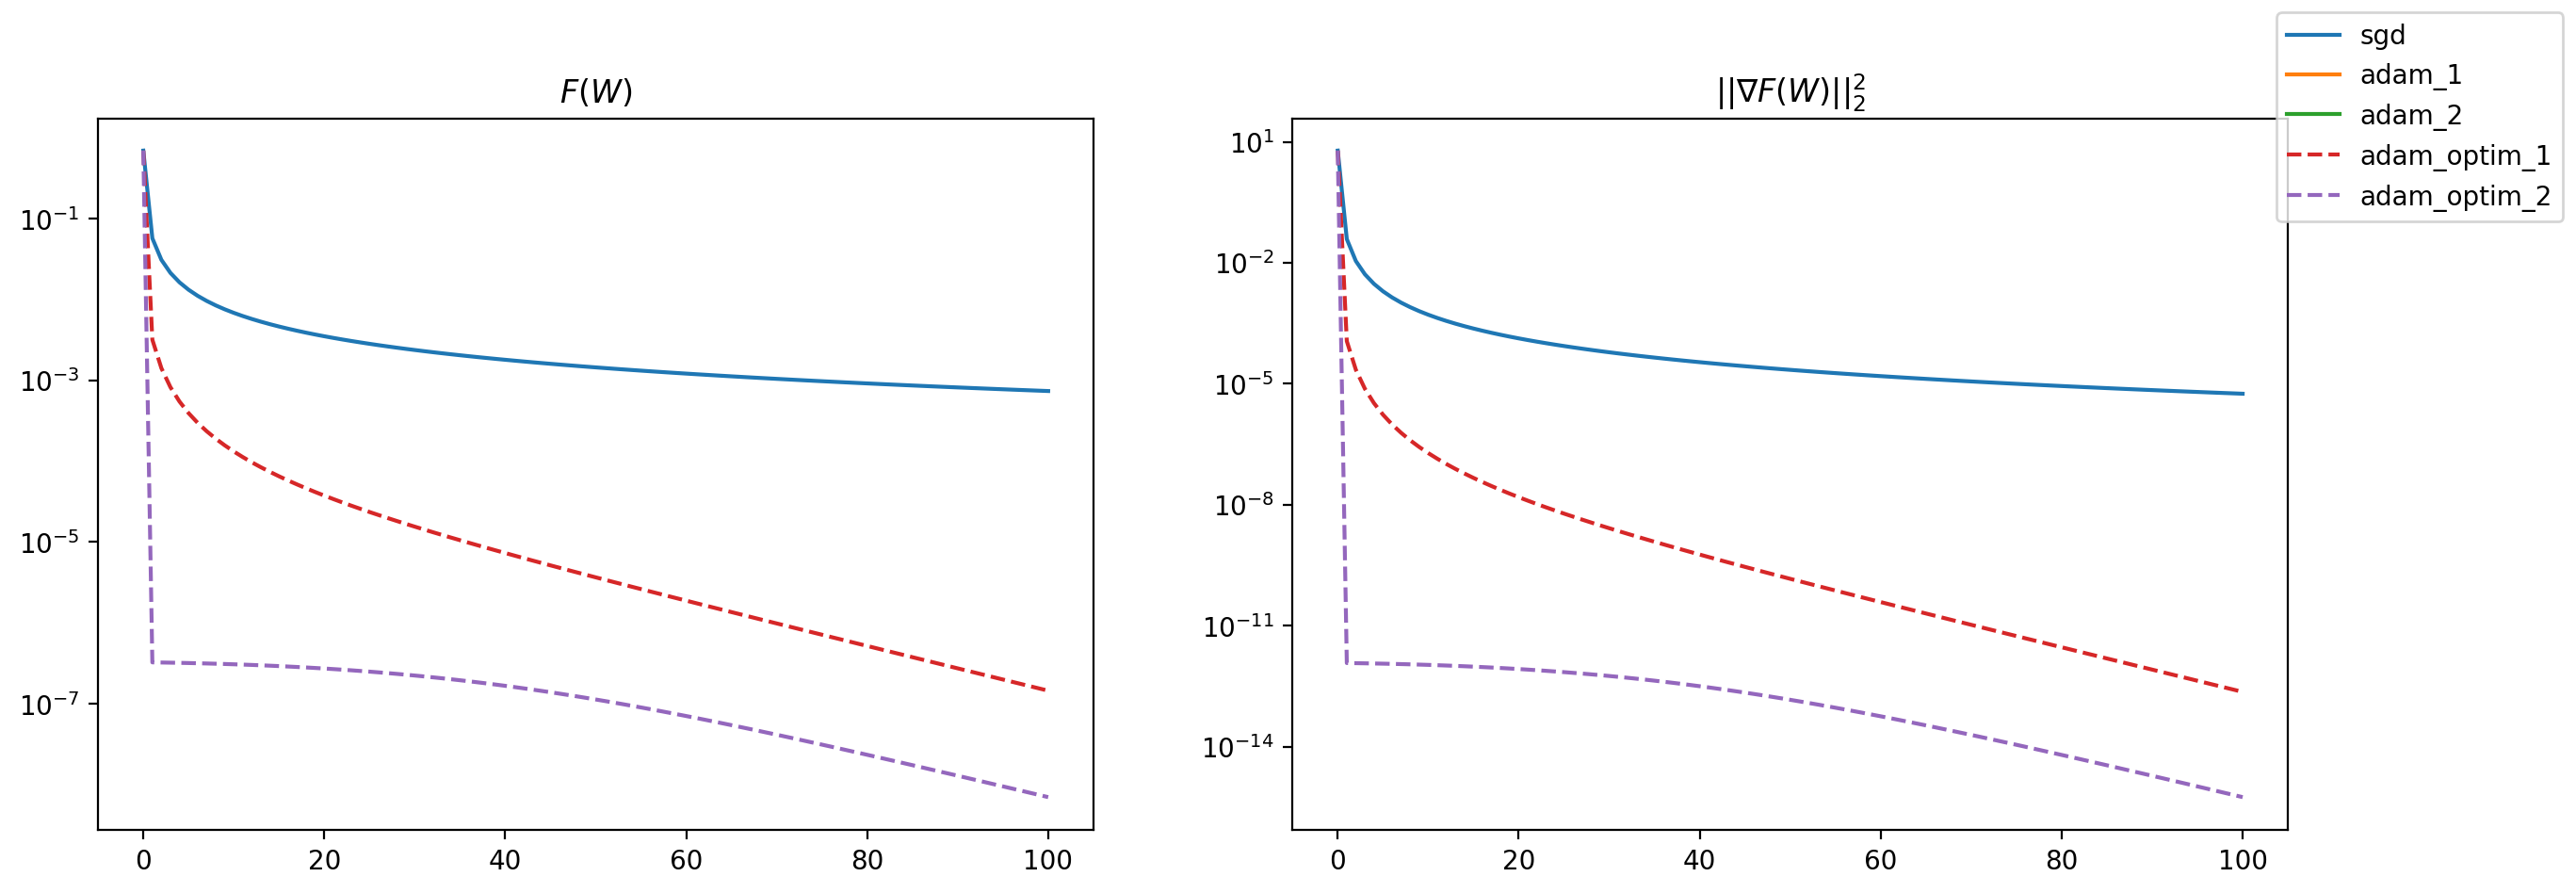

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

ax1.semilogy([x[0] for x in hist_sgd], label="sgd")
ax2.semilogy([x[1] for x in hist_sgd])

ax1.semilogy([x[0] for x in hist_adam_1], label="adam_1")
ax2.semilogy([x[1] for x in hist_adam_1])

ax1.semilogy([x[0] for x in hist_adam_2], label="adam_2")
ax2.semilogy([x[1] for x in hist_adam_2])

ax1.semilogy([x[0] for x in hist_adam_optim_1], linestyle="--", label="adam_optim_1")
ax2.semilogy([x[1] for x in hist_adam_optim_1], linestyle="--")

ax1.semilogy([x[0] for x in hist_adam_optim_2], linestyle="--", label="adam_optim_2")
ax2.semilogy([x[1] for x in hist_adam_optim_2], linestyle="--")


ax1.set_title(r"$F(W)$")
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2_2$")

fig.legend()